In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter

In [2]:
def plot_fundings(data):
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(lambda x, pos: x / 1e9)
    sns.barplot(x='announced_on', y='raised_amount_usd', data=data, palette='winter', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_xlabel('')
    ax.set_ylabel('Capital raised ($B)')

    y = data.raised_amount_usd
    for i, v in enumerate(y):
        ax.text(x=i-0.20, y=v/y.iloc[i] + min(y)/2.5,
                s=int(y.iloc[i] / 1e9),
                rotation=90, fontsize=12, weight='regular')
    plt.show()

In [3]:
rounds = pd.read_csv('../../data/crunchbase/funding_rounds.csv')
rounds.announced_on = pd.to_datetime(rounds.announced_on, errors='coerce')
rounds['year'] = rounds.announced_on.dt.year

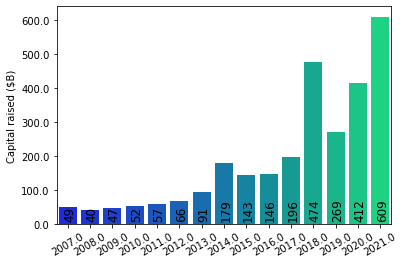

In [4]:
start = 2007
end = 2021

fundings_per_year_US = rounds[(rounds.announced_on.dt.year >= start)
                              & (rounds.announced_on.dt.year <= end)
                              & (rounds.country_code == "USA")]
fundings_per_year_US = fundings_per_year_US[['announced_on', 'raised_amount_usd']]
fundings_per_year_US = fundings_per_year_US.groupby(rounds.announced_on.dt.year).sum().reset_index()

plot_fundings(fundings_per_year_US)

In [5]:
orgs = pd.read_csv('../../data/crunchbase/organizations.csv')

In [6]:
cats = orgs[orgs.uuid.isin(rounds.org_uuid)][['uuid', 'category_groups_list']].dropna()
cats.category_groups_list = cats.category_groups_list.apply(lambda x: x.split(','))
cats.columns = ['org_uuid', 'category']

In [7]:
stages = {
    'early stage': ['angel', 'seed', 'pre_seed', 'product_crowdfunding', 'equity_crowdfunding', 'convertible_note', 'initial_coin_offering'],
    'mid stage': ['series_a', 'series_b', 'corporate_round'],
    'late stage': ['series_c', 'series_d', 'series_e', 'series_f', 'series_i', 'series_g', 'series_h', 'series_j', 'secondary_market'],
    'other': ['post_ipo_equity', 'post_ipo_secondary', 'post_ipo_debt', 'series_unknown', 'undisclosed', 'debt_financing', 'grant', 'non_equity_assistance']
}

stage_map = {}
for k, v in stages.items():
    for x in v:
        stage_map[x] = k

rounds['stage'] = rounds.investment_type.map(stage_map)

In [8]:
start = 2007
end = 2021

fundings_per_year_stage = rounds[(rounds.announced_on.dt.year >= start)
                                 & (rounds.announced_on.dt.year <= end)
                                 & (rounds.country_code == "USA")]
fundings_per_year_stage = fundings_per_year_stage[['year', 'raised_amount_usd', 'stage']].dropna()
fundings_per_year_stage = fundings_per_year_stage.groupby(['year', 'stage']).sum().reset_index()
fundings_per_year_stage = fundings_per_year_stage[fundings_per_year_stage.stage != 'other']

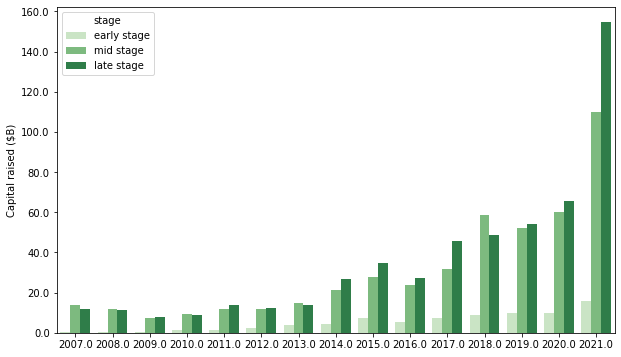

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
ax.yaxis.set_major_formatter(lambda x, pos: x / 1e9)
sns.barplot(x="year", y="raised_amount_usd", hue="stage", hue_order=['early stage', 'mid stage', 'late stage'], data=fundings_per_year_stage, ax=ax, palette='Greens')
ax.set_xlabel('')
ax.set_ylabel('Capital raised ($B)')
plt.savefig('figures/capital_raised.pdf')
plt.show()

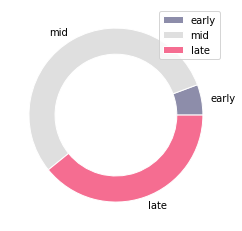

In [10]:
plt.pie(fundings_per_year_stage[fundings_per_year_stage.year == 2021].raised_amount_usd,
        radius=1, wedgeprops=dict(width=0.3, edgecolor='w'), labels=['early', 'mid', 'late'],
        colors=['#8D8DAA', '#DFDFDF', '#F56D91'])
plt.legend()

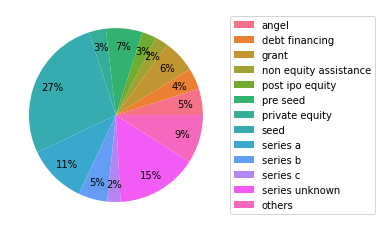

In [11]:
cb_investments = rounds.groupby('investment_type').size() / rounds.shape[0]
cb_investments['others'] = cb_investments[cb_investments < 0.02].sum()
cb_investments = cb_investments[cb_investments >= 0.02]
cb_investments.index = pd.Series(cb_investments.index).apply(lambda s: s.replace('_', ' '))
plt.pie(cb_investments, autopct='%.0f%%', pctdistance=0.8, colors=sns.color_palette("husl", cb_investments.size))
plt.legend(cb_investments.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig('figures/crunchbase_rounds.pdf')
plt.show()

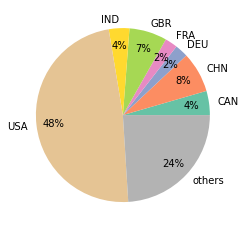

In [12]:
country_freq = rounds.groupby('country_code').size() / rounds.country_code.size
country_freq['others'] = country_freq[country_freq < 0.02].sum()
country_freq = country_freq[country_freq >= 0.02]
plt.pie(country_freq, labels = country_freq.index, autopct='%.0f%%', pctdistance=0.8, colors=sns.color_palette("Set2"))
plt.savefig('figures/crunchbase_countries.pdf')
plt.show()

In [13]:
from tqdm import tqdm
tqdm.pandas()

def get_most_relevant_cat(categories):
    mapped = cat_freqs[cat_freqs.index.isin(categories)]
    return categories[np.argmax(mapped)]

summarized_cats = ['Media',
                   'Software',
                   'IT Hardware',
                   'Consumer Goods & Services',
                   'Consumer Goods & Services',
                   'Media',
                   'Software',
                   'Software',
                   'Media',
                   'Software',
                   'Consumer Goods & Services',
                   'Other',
                   'Commercial Products & Services',
                   'Software',
                   'Media',
                   'IT Hardware',
                   'Transportation',
                   'Other',
                   'Commercial Products & Services',
                   'Commercial Products & Services',
                   'Pharma & Biotech',
                   'Other',
                   'HC Services & Systems',
                   'Other',
                   'Consumer Goods & Services',
                   'Consumer Goods & Services',
                   'Software',
                   'Software',
                   'Consumer Goods & Services',
                   'IT Hardware',
                   'Software',
                   'Transportation',
                   'Commercial Products & Services',
                   'Commercial Products & Services',
                   'Other',
                   'Energy',
                   'Other',
                   'Commercial Products & Services',
                   'Consumer Goods & Services',
                   'Other',
                   'Energy',
                   'Software',
                   'Energy',
                   'Transportation']
cat_freqs = cats.category.explode().value_counts() / cats.category.size
cats.category = cats.category.progress_apply(get_most_relevant_cat)

rounds['category'] = rounds.org_uuid.map(cats.set_index('org_uuid').to_dict()['category'])
rounds['meta_cat'] = rounds.category.map(dict(zip(rounds.category.unique(), summarized_cats)))

100%|██████████| 235993/235993 [00:39<00:00, 5946.80it/s]


In [14]:
start = 2007
end = 2021
fundings_per_year_cat = rounds[(rounds.year >= start)
                               & (rounds.year <= end)
                               & (rounds.country_code == 'USA')][['year', 'meta_cat', 'raised_amount_usd']]
fundings_per_year_cat = fundings_per_year_cat.groupby(['year', 'meta_cat']).sum()

In [15]:
pd.options.display.float_format = '${:,.2f}'.format
fundings_per_year_cat[fundings_per_year_cat.index.get_level_values('year') == 2021] / 1e9

raised_amount_usd
year      meta_cat                                         
$2,021.00 Commercial Products & Services            $200.83
          Consumer Goods & Services                 $112.10
          Energy                                      $6.14
          HC Services & Systems                      $23.88
          IT Hardware                                $15.93
          Media                                      $45.70
          Other                                     $124.14
          Pharma & Biotech                            $9.60
          Software                                   $70.89
          Transportation                              $0.25

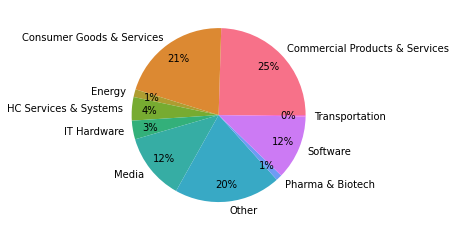

In [16]:
cb_sectors = rounds.groupby('meta_cat').size()
plt.pie(cb_sectors, labels=cb_sectors.index, autopct='%.0f%%', pctdistance=0.8, colors=sns.color_palette("husl", 10))
plt.savefig('crunchbase_sectors.pdf')
plt.show()

In [17]:
rounds[(rounds.post_money_valuation_usd > 0)].sort_values(by='org_name')

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,country_code,state_code,...,post_money_valuation,post_money_valuation_currency_code,investor_count,org_uuid,org_name,lead_investor_uuids,year,stage,category,meta_cat
453988,0f340ff4-4489-4e98-858b-6a11db173ff6,Seed Round - #walk15,funding_round,walk15-229d-seed--0f340ff4,https://www.crunchbase.com/funding_round/walk1...,"$13,729.00",2022-01-19 15:18:26,2022-01-19 15:18:26,LTU,NaN,...,"$5,268,500.00",EUR,$4.00,46c4ee6e-fdda-4bb3-925d-eb8533bc229d,#walk15,NaN,"$2,021.00",early stage,Apps,Commercial Products & Services
299235,6bbaa3b1-813e-441c-832f-c095c0f7b8c7,Secondary Market - &pizza,funding_round,pizza-4-secondary-market--6bbaa3b1,https://www.crunchbase.com/funding_round/pizza...,"$85,472.00",2020-03-03 22:30:46,2020-03-03 22:30:46,USA,DC,...,"$55,000,000.00",USD,$1.00,e098354a-5d4e-9365-0298-c8649e2b4861,&pizza,8487d047-1992-47db-866f-6607accf43de,"$2,019.00",late stage,Food and Beverage,Consumer Goods & Services
299234,14acdcf0-fff9-45e3-9cf7-72f3cabcb9a9,Secondary Market - &pizza,funding_round,pizza-4-secondary-market--14acdcf0,https://www.crunchbase.com/funding_round/pizza...,"$206,295.00",2020-03-03 22:28:27,2020-03-03 22:28:27,USA,DC,...,"$129,800,000.00",USD,$1.00,e098354a-5d4e-9365-0298-c8649e2b4861,&pizza,8487d047-1992-47db-866f-6607accf43de,"$2,019.00",late stage,Food and Beverage,Consumer Goods & Services
253102,a52df74f-84d3-440c-ae0e-e2ad6c70ddfe,Seed Round - .nanobile,funding_round,nanobile-seed--a52df74f,https://www.crunchbase.com/funding_round/nanob...,"$390,760.00",2019-04-23 19:14:34,2019-04-23 19:14:34,SRB,NaN,...,"$8,000,000.00",EUR,NaN,0ecd89e0-5ffb-42c5-8d5f-42bd0db3602f,.nanobile,NaN,"$2,019.00",early stage,Artificial Intelligence,Consumer Goods & Services
425057,6bc23968-88ca-4e9f-a3df-4c6c350130be,Corporate Round - 1 India Family Mart,funding_round,1indiafamilymart-corporate-round--6bc23968,https://www.crunchbase.com/funding_round/1indi...,"$30,326.00",2021-09-10 14:30:16,2021-09-10 14:31:48,IND,NaN,...,"$5,050,000,000.00",INR,$1.00,5dadfece-dce1-4fbf-bc8b-628d32989d4f,1 India Family Mart,6e501388-f847-4e92-ba89-0abc8a75ecd6,"$2,021.00",mid stage,Commerce and Shopping,Consumer Goods & Services
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321817,a8dddeb4-34bd-4332-8372-e36e8d8cf85f,Pre Seed Round - ЭМИИА ИИ (EMIIA.AI),funding_round,emiia-ai-pre-seed--a8dddeb4,https://www.crunchbase.com/funding_round/emiia...,"$462,165.00",2020-07-02 09:47:20,2020-07-02 09:47:20,RUS,NaN,...,"$350,000.00",USD,$1.00,720e888f-8a3d-48f5-bed6-26cb42ba0d7c,ЭМИИА ИИ (EMIIA.AI),b35e276a-8a49-488d-b084-671c5b1c64d8,"$2,017.00",early stage,Artificial Intelligence,Consumer Goods & Services
407944,508d7832-d44e-4b32-93dd-af9ef7a2b2ae,Seed Round - ЭМИИА ИИ (EMIIA.AI),funding_round,emiia-ai-seed--508d7832,https://www.crunchbase.com/funding_round/emiia...,"$86,985.00",2021-06-14 13:21:28,2021-06-14 13:21:28,RUS,NaN,...,"$100,000.00",USD,$1.00,720e888f-8a3d-48f5-bed6-26cb42ba0d7c,ЭМИИА ИИ (EMIIA.AI),1dbc1bd5-7f71-6862-ad39-2c1fd1e16f56,"$2,021.00",early stage,Artificial Intelligence,Consumer Goods & Services
186642,b9642be8-95a3-4d5b-a32d-342f92b4f0f5,Equity Crowdfunding - ​​Zenz Organic,funding_round,zenz-organic-equity-crowdfunding--b9642be8,https://www.crunchbase.com/funding_round/zenz-...,"$273,914.00",2018-01-04 04:55:42,2018-02-12 23:37:22,DNK,NaN,...,"$41,916,720.00",DKK,NaN,85700750-9e29-473b-a5ac-30dbec63e071,​​Zenz Organic,NaN,"$2,018.00",early stage,Consumer Goods,Energy
225022,76591133-f78b-4d61-b035-e91396e64441,Angel Round - 停車大聲公 PKLOT Inc,funding_round,停車大聲公-pklot-inc-angel--76591133,https://www.crunchbase.com/funding_round/停車大聲公...,"$222,101.00",2018-09-16 04:07:34,2018-09-16 04:07:34,TWN,NaN,...,"$115,000.00",USD,$2.00,168e52e0-b9f5-45be-8792-f5c1d96c68d2,停車大聲公 PKLOT Inc,9f85686a-94c1-4440-9847-85cadf9e42b4,"$2,016.00",early stage,Apps,Commercial Products & Services


In [40]:
capitaliq = pd.read_excel('../../data/pmv_not_na.xls', skiprows=6, header=1, na_values='-')
capitaliq.columns = ['announced_on', 'name', 'exchange',
                     'investors', 'status',
                     'amount_raised_usd',
                     'pre_money_valuation',
                     'post_money_valuation',
                     'country', 'round_type',
                     'industry_classification',
                     'Excel Company ID [Target/Issuer]', 'CIK [Target/Issuer]',
                     'SIC Codes (Primary Code Only) [Target/Issuer]']
capitaliq = capitaliq.drop(columns=['exchange', 'Excel Company ID [Target/Issuer]', 'CIK [Target/Issuer]', 'SIC Codes (Primary Code Only) [Target/Issuer]'])
capitaliq

,announced_on,name,investors,status,amount_raised_usd,pre_money_valuation,post_money_valuation,country,round_type,industry_classification
0,2021-09-06,Alif Bank OJSC,Jefferson Capital Holdings Llc,Closed,$8.00,$92.00,$100.00,NaN,Growth,Banks (Primary); Banks (Primary); Financials (...
1,2021-10-13,"Dexterity, Inc.",Kleiner Perkins Caufield & Byers; Presidio STX...,Closed,$140.00,"$1,260.00","$1,400.00",United States,Series B,Capital Goods (Primary); Industrial Machinery ...
2,2015-11-25,"Seaport Diagnostics, Inc.",180 Degree Capital Corp. (NasdaqGM:TURN); DEFT...,Closed,$12.50,$10.99,$23.49,United States,Series A,Biotechnology (Primary); Biotechnology (Primar...
3,2018-06-12,"Seaport Diagnostics, Inc.",Laboratory Corporation of America Holdings (NY...,Closed,$26.17,$67.26,$93.43,United States,Series B,Biotechnology (Primary); Biotechnology (Primar...
4,2001-01-31,"(X,Y,Z) Imaging Inc.",NaN,Effective,$1.88,$2.64,$4.52,NaN,Series A,Commercial and Professional Services (Primary)...
...,...,...,...,...,...,...,...,...,...,...
9995,2017-06-08,"Hangzhou DT Dream Technology Co., Ltd.",Alibaba Group Holding Limited (NYSE:BABA); Zhe...,Closed,$110.29,$892.35,"$1,002.65",China,Series A,Information Technology (Primary); Infrastructu...
9996,2019-09-26,"Hangzhou DT Dream Technology Co., Ltd.","Zheshang Venture Capital Co., Ltd; Zhejiang St...",Closed,$84.12,"$1,415.88","$1,500.00",China,Series B,Information Technology (Primary); Infrastructu...
9997,2015-10-29,"Hangzhou Duiba Network Technology Co., Ltd.",NaN,Closed,$4.25,$27.22,$31.47,NaN,Series B,Information Technology (Primary); Information ...
9998,2014-08-31,"Hangzhou Enniu Network Technology Co., Ltd.","GGV Capital, LLC; JD.com, Inc. (NasdaqGS:JD); ...",Closed,$50.00,$250.00,$300.00,NaN,Series B,Application Software (Primary); Information Te...


In [44]:
capitaliq.announced_on[0].day

6